In [335]:
import json
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


def load_json(file_path):
    with open(f"{file_path}") as f:
        data = json.load(f)
    return data

def write_json(data, file_path):
    with open(f"{file_path}", "w") as f:
        json.dump(data, f, indent=4)

def load_csv(file_path):
    with open(file_path, "r") as f:
        # split by ;
        data = f.readlines()
        header = data[0].split(";")
        data = [line.split(";") for line in data[1:]]
        data = [dict(zip(header, line)) for line in data]
    return data

### Summary Only

In [336]:
summary_only_results = load_json("../data/evaluation/ir/evaluation_results-2025-03-18-15-15-43.json")

print(f"Number of Documents: {len(summary_only_results['evaluation_results'][0]['ir_results']['similarity_scores'])} \n\n")

print(f"Retrieval Results for Approach Table Summary Only")

results = summary_only_results['evaluation_results'][0]['ir_results']

print(f"  Document Precision@5: {results['document_precision']:.2f}") # how many of the retrieved documents are correct (relevant)
print("  Results on Match Within Related Table")
print(f"    Chunk Recall@1: {results['chunk_recall_1_coarse']:.2f}")
print(f"    Chunk Recall@3: {results['chunk_recall_3_coarse']:.2f}")
print(f"    Chunk Recall@5: {results['chunk_recall_5_coarse']:.2f}")
print(f"    Chunk MRR@5: {results['chunk_mrr_5_coarse']:.2f}")


Number of Documents: 288 


Retrieval Results for Approach Table Summary Only
  Document Precision@5: 0.99
  Results on Match Within Related Table
    Chunk Recall@1: 0.32
    Chunk Recall@3: 0.63
    Chunk Recall@5: 0.71
    Chunk MRR@5: 0.47


### Baselines

In [337]:
baseline_results = load_json("../data/evaluation/ir/evaluation_results-2025-03-18-18-42-11.json")


approaches = ["html", "csv", "json-records", "markdown"]
approach_name = ["HTML", "CSV", "JSON Records", "Markdown"]

for k, approach in enumerate(approaches):
    for j, merging_approach in enumerate(["without-merging", "with-merging"]):
        i = j*len(approaches) + k
        
        print(f"Retrieval Results for Approach {approach_name[k]} -- {merging_approach}")
        
        results = baseline_results['evaluation_results'][i]['ir_results']
        
        print(f"  Document Precision@5: {results['document_precision']:.2f}") # how many of the retrieved documents are correct (relevant)

        print("  Results on Match Within Chunk")
        print(f"    Chunk Recall@1: {results['chunk_recall_1_detailed']:.2f}") 
        print(f"    Chunk Recall@3: {results['chunk_recall_3_detailed']:.2f}")
        print(f"    Chunk Recall@5: {results['chunk_recall_5_detailed']:.2f}")   
        print(f"    Chunk MRR@5: {results['chunk_mrr_5_detailed']:.2f}")
        
        print("  Results on Match Within Related Table")
        print(f"    Chunk Recall@1: {results['chunk_recall_1_coarse']:.2f}")
        print(f"    Chunk Recall@3: {results['chunk_recall_3_coarse']:.2f}")
        print(f"    Chunk Recall@5: {results['chunk_recall_5_coarse']:.2f}")
        print(f"    Chunk MRR@5: {results['chunk_mrr_5_coarse']:.2f}")

        
        print("\n")
        


Retrieval Results for Approach HTML -- without-merging
  Document Precision@5: 0.99
  Results on Match Within Chunk
    Chunk Recall@1: 0.19
    Chunk Recall@3: 0.46
    Chunk Recall@5: 0.57
    Chunk MRR@5: 0.33
  Results on Match Within Related Table
    Chunk Recall@1: 0.20
    Chunk Recall@3: 0.52
    Chunk Recall@5: 0.66
    Chunk MRR@5: 0.37


Retrieval Results for Approach HTML -- with-merging
  Document Precision@5: 1.00
  Results on Match Within Chunk
    Chunk Recall@1: 0.15
    Chunk Recall@3: 0.41
    Chunk Recall@5: 0.55
    Chunk MRR@5: 0.29
  Results on Match Within Related Table
    Chunk Recall@1: 0.17
    Chunk Recall@3: 0.53
    Chunk Recall@5: 0.70
    Chunk MRR@5: 0.36


Retrieval Results for Approach CSV -- without-merging
  Document Precision@5: 0.99
  Results on Match Within Chunk
    Chunk Recall@1: 0.18
    Chunk Recall@3: 0.51
    Chunk Recall@5: 0.58
    Chunk MRR@5: 0.34
  Results on Match Within Related Table
    Chunk Recall@1: 0.19
    Chunk Recall@3: 0.

### TabTree Primary Subtree

In [338]:
def reset_plot_dicts():
    plot_dict_exact_match = {
        "base": {
            "without-merging": {
                "heuristic": [],
                "column-header-tree": [],
                "row-label-tree": [],
                "concatenate": []
            },
        },
        "text": {
            "without-merging": {
                "heuristic": [],
                "column-header-tree": [],
                "row-label-tree": [],
                "concatenate": []
            },
        }
    }

    plot_dict_related_match = {
        "base": {
            "without-merging": {
                "heuristic": [],
                "column-header-tree": [],
                "row-label-tree": [],
                "concatenate": []
            },
        },
        "text": {
            "without-merging": {
                "heuristic": [],
                "column-header-tree": [],
                "row-label-tree": [],
                "concatenate": []
            },
        }
    }
    
    return plot_dict_exact_match, plot_dict_related_match


In [339]:
plot_dict_exact_match, plot_dict_related_match = reset_plot_dicts()

primary_subtree_results = load_json("../data/evaluation/ir/evaluation_results-2025-03-18-23-30-21.json")




approaches = ["base", "text"]
approach_name = ["Base", "Text"]

subtree_approaches = ["heuristic", "column-header-tree", "row-label-tree", "concatenate"]
subtree_approaches_name = ["Heuristic", "Column Header Tree", "Row Label Tree", "Concatenate"]

for k, approach in enumerate(approaches):
    for i, subtree_approach in enumerate(subtree_approaches):
        for j, merging_approach in enumerate(["without-merging", "with-merging"]):
            name = f"primary-subtree-{merging_approach}-tabtree-{approach}-{subtree_approach}"
            results_dict = next((item for item in primary_subtree_results['evaluation_results'] if item["name"] == name), None)
            if not results_dict:
                raise ValueError(f"Could not find results for {name}")
            
            
            
            
            print(f"Retrieval Results for Primary Subtree Approach {subtree_approaches_name[i]} -- {approach_name[k]} -- {merging_approach}")
            
            results = results_dict['ir_results']
            
            print(f"  Document Precision@5: {results['document_precision']:.2f}") # how many of the retrieved documents are correct (relevant)

            print("  Results on Match Within Chunk")
            print(f"    Chunk Recall@1: {results['chunk_recall_1_detailed']:.2f}") 
            print(f"    Chunk Recall@3: {results['chunk_recall_3_detailed']:.2f}")
            print(f"    Chunk Recall@5: {results['chunk_recall_5_detailed']:.2f}")   
            print(f"    Chunk MRR@5: {results['chunk_mrr_5_detailed']:.2f}")
            
            
            
            print("  Results on Match Within Related Table")
            print(f"    Chunk Recall@1: {results['chunk_recall_1_coarse']:.2f}")
            print(f"    Chunk Recall@3: {results['chunk_recall_3_coarse']:.2f}")
            print(f"    Chunk Recall@5: {results['chunk_recall_5_coarse']:.2f}")
            print(f"    Chunk MRR@5: {results['chunk_mrr_5_coarse']:.2f}")
            

            
            print("\n")
            
            
            if merging_approach == "without-merging":
                results = results_dict['ir_results']
                results_1 = results['chunk_recall_1_detailed']
                results_3 = results['chunk_recall_3_detailed']
                results_5 = results['chunk_recall_5_detailed']        
                
                plot_dict_exact_match[approach][merging_approach][subtree_approach].append([results_1, results_3, results_5])

                results_1_coarse = results['chunk_recall_1_coarse']
                results_3_coarse = results['chunk_recall_3_coarse']
                results_5_coarse = results['chunk_recall_5_coarse']
                
                plot_dict_related_match[approach][merging_approach][subtree_approach].append([results_1_coarse, results_3_coarse, results_5_coarse])
                
            


Retrieval Results for Primary Subtree Approach Heuristic -- Base -- without-merging
  Document Precision@5: 0.99
  Results on Match Within Chunk
    Chunk Recall@1: 0.26
    Chunk Recall@3: 0.58
    Chunk Recall@5: 0.72
    Chunk MRR@5: 0.43
  Results on Match Within Related Table
    Chunk Recall@1: 0.30
    Chunk Recall@3: 0.62
    Chunk Recall@5: 0.75
    Chunk MRR@5: 0.46


Retrieval Results for Primary Subtree Approach Heuristic -- Base -- with-merging
  Document Precision@5: 0.99
  Results on Match Within Chunk
    Chunk Recall@1: 0.19
    Chunk Recall@3: 0.48
    Chunk Recall@5: 0.62
    Chunk MRR@5: 0.34
  Results on Match Within Related Table
    Chunk Recall@1: 0.20
    Chunk Recall@3: 0.52
    Chunk Recall@5: 0.65
    Chunk MRR@5: 0.37


Retrieval Results for Primary Subtree Approach Column Header Tree -- Base -- without-merging
  Document Precision@5: 0.99
  Results on Match Within Chunk
    Chunk Recall@1: 0.26
    Chunk Recall@3: 0.58
    Chunk Recall@5: 0.70
    Chunk MR

{'base': {'without-merging': {'heuristic': [[0.2638888888888889, 0.5763888888888888, 0.7152777777777778]], 'column-header-tree': [[0.2604166666666667, 0.5763888888888888, 0.7048611111111112]], 'row-label-tree': [[0.2534722222222222, 0.5173611111111112, 0.6631944444444444]], 'concatenate': [[0.13541666666666666, 0.4236111111111111, 0.5659722222222222]]}}, 'text': {'without-merging': {'heuristic': [[0.041666666666666664, 0.1111111111111111, 0.1701388888888889]], 'column-header-tree': [[0.04513888888888889, 0.1111111111111111, 0.2048611111111111]], 'row-label-tree': [[0.06944444444444445, 0.19791666666666666, 0.2673611111111111]], 'concatenate': [[0.024305555555555556, 0.11805555555555555, 0.18055555555555555]]}}}


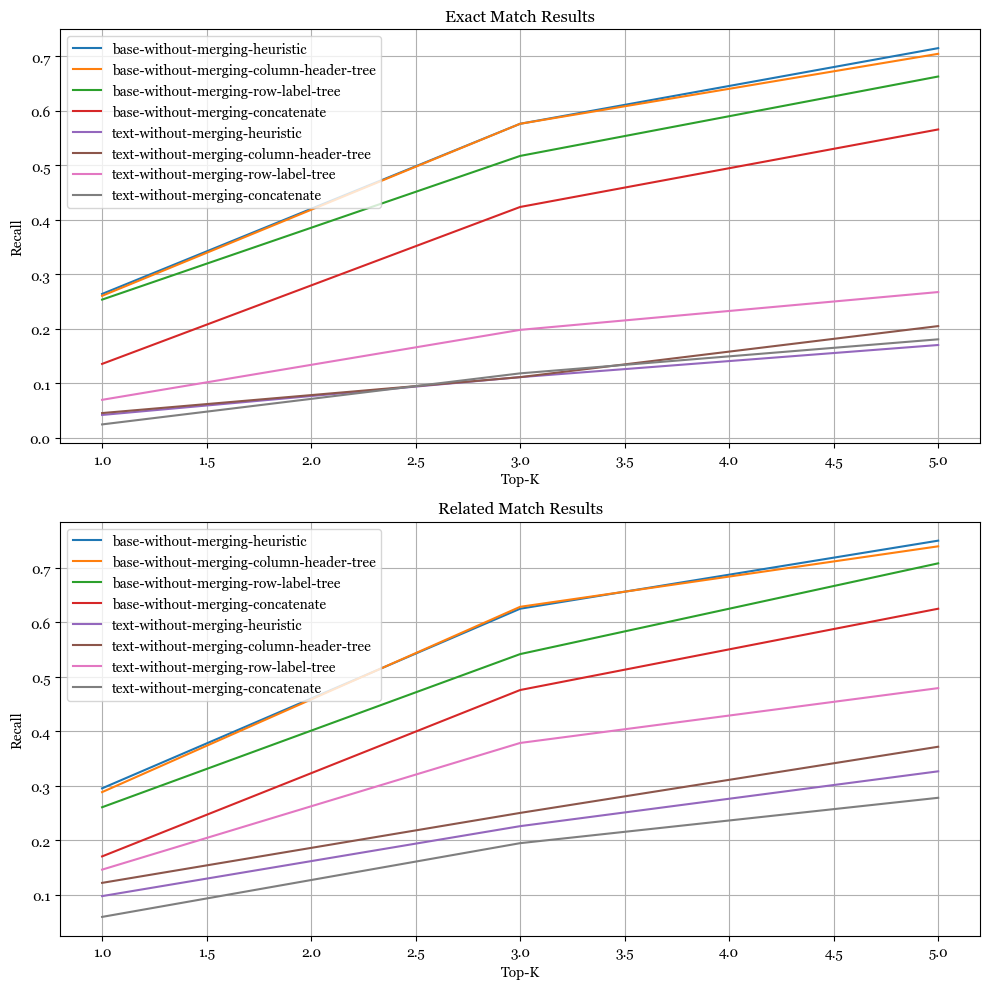

In [340]:


for k, approach in enumerate(approaches):
    for i, subtree_approach in enumerate(subtree_approaches):
        for j, merging_approach in enumerate(["without-merging"]):
            name = f"primary-subtree-{merging_approach}-tabtree-{approach}-{subtree_approach}"
            results_dict = next((item for item in primary_subtree_results['evaluation_results'] if item["name"] == name), None)
            if not results_dict:
                raise ValueError(f"Could not find results for {name}")
            
            
            

print(plot_dict_exact_match)
# Plot the results as line plots within one figure with items on x axis 1, 3, 5
x = [1, 3, 5]  # Items on the x-axis
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot exact match results
for approach in plot_dict_exact_match:
    for merging_approach in plot_dict_exact_match[approach]:
        for subtree_approach in plot_dict_exact_match[approach][merging_approach]:
            y = np.mean(plot_dict_exact_match[approach][merging_approach][subtree_approach], axis=0)
            ax[0].plot(x, y, label=f"{approach}-{merging_approach}-{subtree_approach}")

ax[0].set_title("Exact Match Results")
ax[0].set_xlabel("Top-K")
ax[0].set_ylabel("Recall")
ax[0].legend(loc="best")
ax[0].grid(True)

# Plot related match results
for approach in plot_dict_related_match:
    for merging_approach in plot_dict_related_match[approach]:
        for subtree_approach in plot_dict_related_match[approach][merging_approach]:
            y = np.mean(plot_dict_related_match[approach][merging_approach][subtree_approach], axis=0)
            ax[1].plot(x, y, label=f"{approach}-{merging_approach}-{subtree_approach}")

ax[1].set_title("Related Match Results")
ax[1].set_xlabel("Top-K")
ax[1].set_ylabel("Recall")
ax[1].legend(loc="best")
ax[1].grid(True)

plt.tight_layout()
plt.show()




            
            

### TabTree - All

In [341]:
plot_merging = {
    "base": {
        "without-merging" : [],
        "with-merging" : []
    },
    "text-augmented-with-context-intersection": {
        "without-merging" : [],
        "with-merging" : []
    },
    "context-empty": {
        "without-merging" : [],
        "with-merging" : []
    },
}

In [342]:
tabtree_results = load_json("../data/evaluation/ir/evaluation_results-2025-03-18-17-01-43.json")


approaches = ["base", "text", "text-with-context-intersection", "text-augmented-with-context-intersection", "context-empty"]
approach_name = ["Base", "Text", "Text w/ Context-I.", "Text-Augmented w/ Context-I.", "Context Empty"]

for k, approach in enumerate(approaches):
    for j, merging_approach in enumerate(["without-merging", "with-merging"]):
        name = f"tabtree-{merging_approach}-tabtree-{approach}"
        results_dict = next((item for item in tabtree_results['evaluation_results'] if item["name"] == name), None)
        if not results_dict:
            raise ValueError(f"Could not find results for {name}")
        
        
        
        
        print(f"Retrieval Results for Primary Subtree Approach {approach_name[k]} -- {merging_approach}")
        
        results = results_dict['ir_results']
        
        print(f"  Document Precision@5: {results['document_precision']:.2f}") # how many of the retrieved documents are correct (relevant)

        print("  Results on Match Within Chunk")
        print(f"    Chunk Recall@1: {results['chunk_recall_1_detailed']:.2f}") 
        print(f"    Chunk Recall@3: {results['chunk_recall_3_detailed']:.2f}")
        print(f"    Chunk Recall@5: {results['chunk_recall_5_detailed']:.2f}")   
        print(f"    Chunk MRR@5: {results['chunk_mrr_5_detailed']:.2f}")
        
        print("  Results on Match Within Related Table")
        print(f"    Chunk Recall@1: {results['chunk_recall_1_coarse']:.2f}")
        print(f"    Chunk Recall@3: {results['chunk_recall_3_coarse']:.2f}")
        print(f"    Chunk Recall@5: {results['chunk_recall_5_coarse']:.2f}")
        print(f"    Chunk MRR@5: {results['chunk_mrr_5_coarse']:.2f}")

        
        print("\n")
        
        
        if approach in plot_merging:
            results_1_coarse = results['chunk_recall_1_coarse']
            results_3_coarse = results['chunk_recall_3_coarse']
            results_5_coarse = results['chunk_recall_5_coarse']
            
            plot_merging[approach][merging_approach].append([results_1_coarse, results_3_coarse, results_5_coarse])

Retrieval Results for Primary Subtree Approach Base -- without-merging
  Document Precision@5: 0.99
  Results on Match Within Chunk
    Chunk Recall@1: 0.27
    Chunk Recall@3: 0.57
    Chunk Recall@5: 0.71
    Chunk MRR@5: 0.43
  Results on Match Within Related Table
    Chunk Recall@1: 0.30
    Chunk Recall@3: 0.62
    Chunk Recall@5: 0.74
    Chunk MRR@5: 0.46


Retrieval Results for Primary Subtree Approach Base -- with-merging
  Document Precision@5: 0.99
  Results on Match Within Chunk
    Chunk Recall@1: 0.19
    Chunk Recall@3: 0.49
    Chunk Recall@5: 0.64
    Chunk MRR@5: 0.35
  Results on Match Within Related Table
    Chunk Recall@1: 0.21
    Chunk Recall@3: 0.55
    Chunk Recall@5: 0.67
    Chunk MRR@5: 0.38


Retrieval Results for Primary Subtree Approach Text -- without-merging
  Document Precision@5: 0.99
  Results on Match Within Chunk
    Chunk Recall@1: 0.06
    Chunk Recall@3: 0.14
    Chunk Recall@5: 0.22
    Chunk MRR@5: 0.11
  Results on Match Within Related Tabl

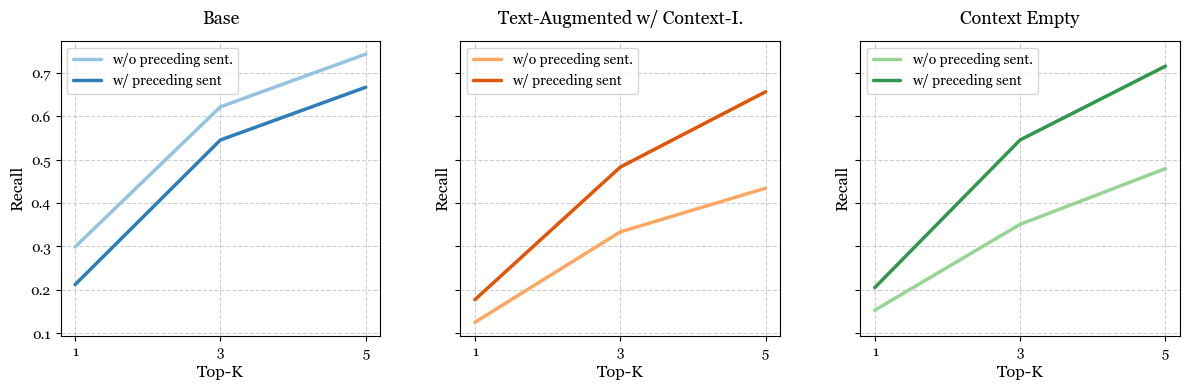

In [343]:
# Plot plot_merging dict for each of the three items as three plots next to each other.
# For each item, provide line charts for the cases "with-merging" and "without-merging".

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

x = [1, 3, 5]  # Items on the x-axis

for idx, (approach, data) in enumerate(plot_merging.items()):
    for color_idx, (merging_approach, values) in enumerate(data.items()):
        if values:  # Ensure there is data to plot
            y = np.mean(values, axis=0)
            axes[idx].plot(
                x, y, 
                label=f"{merging_approach}", 
                color=plt.cm.Blues(0.4 + 0.6 * (color_idx / len(data))) if idx == 0 else 
                      plt.cm.Oranges(0.4 + 0.6 * (color_idx / len(data))) if idx == 1 else 
                      plt.cm.Greens(0.4 + 0.6 * (color_idx / len(data))), 
                linewidth=2.5, 
                solid_capstyle='round'
            )
    
    axes[idx].set_xlabel("Top-K", fontname='Georgia', fontsize=12)
    axes[idx].set_ylabel("Recall", fontname='Georgia', fontsize=12)
    axes[idx].set_title(f"{approach_name[approaches.index(approach)]}", fontname='Georgia', fontsize=13, pad=12)
    axes[idx].legend(loc="best", fontsize=10, prop={'family': 'Georgia'})
    axes[idx].grid(True, linestyle='--', alpha=0.6)
    axes[idx].legend(
        loc="best", 
        fontsize=10, 
        prop={'family': 'Georgia'}, 
        labels=[label.replace("without-merging", "w/o preceding sent.").replace("with-merging", "w/ preceding sent") for label in axes[idx].get_legend_handles_labels()[1]]
    )
# Set the font for the entire figure
plt.rcParams['font.family'] = 'Georgia'

for ax in axes:
    ax.set_xticks(x)


fig.subplots_adjust(wspace=1.7)  # Adjust spacing as needed
plt.tight_layout()
plt.show()

# save figure as pdf
fig.savefig("../data/results/retrieval-tabtree-merging.pdf", bbox_inches="tight")



### Table Length Analysis

In [344]:
import tiktoken


def num_tokens_from_string(string: str, encoding_name: str = "o200k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def mrr_from_list(results: list) -> float:
    """Calculates the Mean Reciprocal Rank (MRR) from a list of results."""
    mrr = 0
    for result in results:
        if result > 0:
            mrr += 1 / result
            
    mrr /= len(results)
    return mrr

/var/folders/7d/g2j4hccn7pxdk3cp75110hcr0000gn/T/ipykernel_70334/3907731152.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20b', 2)


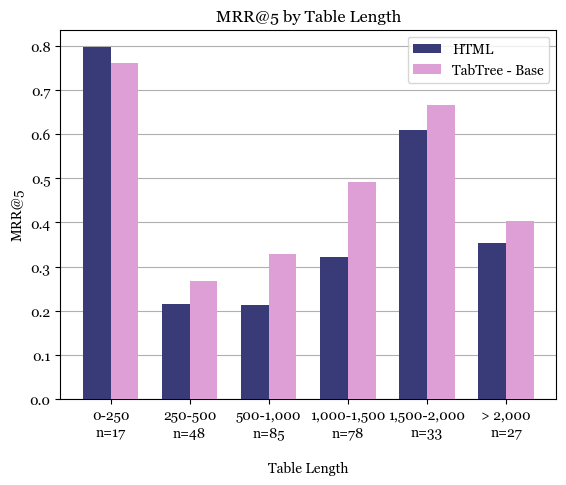

In [345]:
# load data/evaluation/ir/match_list-2025-03-27-21-38-12.json
from matplotlib import cm


match_list_html = load_json("../data/evaluation/ir/match_list-2025-03-27-22-48-09.json")
match_list_tabtree = load_json("../data/evaluation/ir/match_list-2025-03-27-22-28-00.json")



table_lengths = [num_tokens_from_string(question["question_html_table_parsed"][0]) for question in match_list_html]

table_length_bins = [250, 500, 1000, 1500, 2000, 8000]
table_length_bin_descriptions_start = ["0-250", "250-500", "500-1,000", "1,000-1,500", "1,500-2,000", "> 2,000"]

# produce a dict with a list of match numbers for each bin
table_length_bins_dict_html = {bin: [] for bin in table_length_bins}

for i, (match_item, table_length) in enumerate(zip(match_list_html, table_lengths)):
    for bin in table_length_bins:
        if table_length <= bin:
            table_length_bins_dict_html[bin].append(match_item["match"])
            break
        
table_length_bins_dict_tabtree = {bin: [] for bin in table_length_bins}        
for i, (match_item, table_length) in enumerate(zip(match_list_tabtree, table_lengths)):
    for bin in table_length_bins:
        if table_length <= bin:
            table_length_bins_dict_tabtree[bin].append(match_item["match"])
            break
        
        
table_length_bins_descriptions = []
for bin_index, bin in enumerate(table_length_bins):
    table_length_bins_descriptions.append(table_length_bin_descriptions_start[bin_index] + f"\nn={len(table_length_bins_dict_html[bin])}\n")

# generate list sorted by category for plotting
category_mrr_dict_html = [mrr_from_list(table_length_bins_dict_html[bin]) for bin in table_length_bins]
category_mrr_dict_tabtree = [mrr_from_list(table_length_bins_dict_tabtree[bin]) for bin in table_length_bins]
categories = table_length_bins_descriptions
wrapped_labels = table_length_bins_descriptions

# Define colors for each category
colors = cm.get_cmap('tab20b', 2)

fig, ax = plt.subplots()
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, category_mrr_dict_html, width, label='HTML', color=colors(0), zorder=3)
rects2 = ax.bar(x + width/2, category_mrr_dict_tabtree, width, label='TabTree - Base' , color=colors(1), zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MRR@5', fontname='Georgia')
ax.set_xlabel('Table Length', fontname='Georgia')
ax.set_title('MRR@5 by Table Length', fontname='Georgia')
ax.set_xticks(x)

ax.set_xticklabels(wrapped_labels, fontname='Georgia')
ax.legend(prop={'family': 'Georgia'})

ax.yaxis.grid(True, zorder=0)
ax.set_axisbelow(True)  # Move grid to background

plt.show()

# save plot to pdf
fig.savefig("../data/results/retrieval_mrr_5_by_table_length.pdf", bbox_inches='tight')

            


    



### Question Category Check

/var/folders/7d/g2j4hccn7pxdk3cp75110hcr0000gn/T/ipykernel_70334/1056681116.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20b', 2)


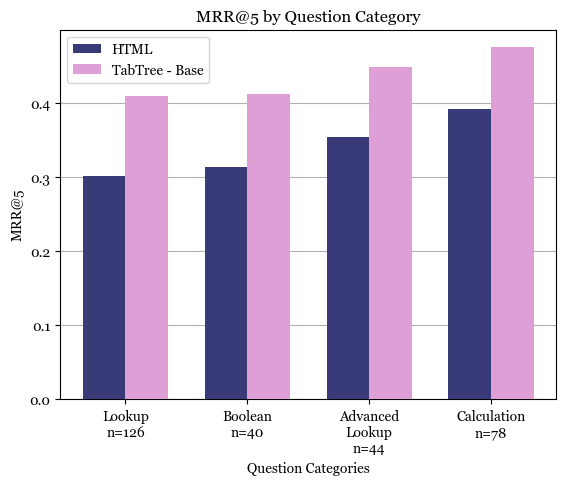

In [346]:
import textwrap

from matplotlib import cm



# create list for each category
category_match_dict_html = {}
for question in match_list_html:
    if question["question_category"] not in category_match_dict_html:
        category_match_dict_html[question["question_category"]] = []
    category_match_dict_html[question["question_category"]].append(question["match"])

    
# calculate mrr for each category:
category_mrr_dict_html = {}
for category, matches in category_match_dict_html.items():
    mrr = mrr_from_list(matches)
    category_mrr_dict_html[category] = mrr


# create list for each category -- tabtree
category_match_dict_tabtree = {}
for question in match_list_tabtree:
    if question["question_category"] not in category_match_dict_tabtree:
        category_match_dict_tabtree[question["question_category"]] = []
    category_match_dict_tabtree[question["question_category"]].append(question["match"])


# calculate mrr for each category -- tabtree:
category_mrr_dict_tabtree = {}
for category, matches in category_match_dict_tabtree.items():
    mrr = mrr_from_list(matches)
    category_mrr_dict_tabtree[category] = mrr


# plot accuracy for each category as grouped bar chart for phi-4 vs html
categories = ["lookup", "boolean", "advanced lookup", "calculation"]

# generate list sorted by category for plotting
category_mrr_dict_html = [category_mrr_dict_html[category] for category in categories]
category_mrr_dict_tabtree = [category_mrr_dict_tabtree[category] for category in categories]


# count the number of questions in each category
category_counts = {}
for question in match_list:
    if question["question_category"] not in category_counts:
        category_counts[question["question_category"]] = 0
    category_counts[question["question_category"]] += 1


# Wrap labels if they are too long
wrapped_labels = []
for label in categories:
    wrapped_label = textwrap.fill(" ".join(word.capitalize() for word in label.split()), 11)
    wrapped_label += f"\nn={category_counts[label]}"
    wrapped_labels.append(wrapped_label)



# Define colors for each category
colors = cm.get_cmap('tab20b', 2)

fig, ax = plt.subplots()
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, category_mrr_dict_html, width, label='HTML', color=colors(0), zorder=3)
rects2 = ax.bar(x + width/2, category_mrr_dict_tabtree, width, label='TabTree - Base' , color=colors(1), zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MRR@5', fontname='Georgia')
ax.set_xlabel('Question Categories', fontname='Georgia')
ax.set_title('MRR@5 by Question Category', fontname='Georgia')
ax.set_xticks(x)
ax.set_xticklabels(wrapped_labels, fontname='Georgia')
ax.legend(prop={'family': 'Georgia'})


ax.yaxis.grid(True, zorder=0)
ax.set_axisbelow(True)  # Move grid to background

plt.show()

# save plot to pdf
fig.savefig("../data/results/retrieval_mrr_5_by_category.pdf", bbox_inches='tight')








